In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random
import cv2
from statistics import mode
import math
# from google.colab import drive
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score



In [2]:
def load_dataset():
    image_pickle_file_path = 'images.pkl'
    label_pickle_file_path = 'label.pkl'
    # drive.mount('/content/drive')
    with open(image_pickle_file_path, 'rb') as file:
        images = pickle.load(file)

    with open(label_pickle_file_path, 'rb') as file:
        labels = pickle.load(file)
    # images = np.load('drive/MyDrive/Colab Notebooks/images.pkl', allow_pickle = True)
    # labels = np.load('drive/MyDrive/Colab Notebooks/label.pkl', allow_pickle = True)
    features = []
    # pixel_locations = []
    # hsv_values = []
    for image in images:
        n, m, _ = image.shape
        indices = np.indices((n, m))

        pixel_img = np.column_stack((indices[0].ravel(), indices[1].ravel()))
        # pixel_locations.append(pixel_img)

        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        hsv = hsv_image.reshape(n*m, -1)
        # hsv_values.append(hsv)
        feature_image = np.column_stack((hsv,pixel_img))
        features.append(feature_image)
    # return images, labels, pixel_locations, hsv_values , features
    return images ,labels, features

In [3]:
# Classify the datapoints with the Random Forest Classifier
def classify_for_delete(feature_vectors, labels):


    # feature_vectors = np.array(feature_vectors)
   

    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=test_size, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_test,y_pred,X_test,accuracy

In [4]:
# Classify the datapoints with the Random Forest Classifier
def classify(feature_vectors, labels):


    feature_vectors = np.array(feature_vectors)
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_vectors[:, :])

    weighted_features = np.empty([len(normalized_features), 10])
    weighted_features[:, 0] = normalized_features[:, 0] * 3
    weighted_features[:, 1] = normalized_features[:, 1] * 2
    weighted_features[:, 2] = normalized_features[:, 2] * 2
    weighted_features[:, 3] = normalized_features[:, 3] * 2
    weighted_features[:, 4] = normalized_features[:, 4] * 2
    weighted_features[:, 5] = normalized_features[:, 5] * 1
    weighted_features[:, 6] = normalized_features[:, 6] * 1
    weighted_features[:, 7] = normalized_features[:, 7] * 1
    weighted_features[:, 8] = normalized_features[:, 8] * 2
    weighted_features[:, 9] = normalized_features[:, 9] * 2
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(weighted_features, labels, test_size=test_size, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_test,y_pred,accuracy

In [6]:

def extract_flower_new(features):
    numberCluster = 3
    scaler = StandardScaler()
    width = np.max(features[:, 3])#center of the image
    height = np.max(features[:, 4])
    center_x =  width / 2
    center_y = height / 2
    original_hue_values = features[:, 0].copy()
    #  horizontal and vertical space each pixel and the center
    horizontal_space = np.abs(features[:, 3] - center_x)
    vertical_space = np.abs(features[:, 4] - center_y)
    
    horizontal_space_normalized = scaler.fit_transform(horizontal_space.reshape(-1, 1))
    vertical_space_normalized = scaler.fit_transform(vertical_space.reshape(-1, 1))

    for i in range(len(original_hue_values)): 
            hue = original_hue_values[i]
            if 0 <= hue < 30: 
                original_hue_values[i] = 10  # red 
            elif 30 <= hue < 60: 
                original_hue_values[i] = 8 
            elif 60 <= hue < 90: 
                original_hue_values[i] = 4 
            elif 91 <= hue < 150: 
                original_hue_values[i] = 2  
            elif 150 <= hue < 210: 
                original_hue_values[i] = 6 
            elif 271 <= hue < 330: 
                original_hue_values[i] = 7 
            elif 331 <= hue < 360: 
                original_hue_values[i] = 9 
    
    normalized_features = scaler.fit_transform(features[:, 1:5])       
    weighted_features = np.empty([len(normalized_features), 7]) 
    normalized_hue_values =scaler.fit_transform(original_hue_values.reshape(-1, 1))  
    weighted_features[:, 1] = normalized_features[:, 0] * 5
    weighted_features[:, 2] = normalized_features[:, 1] * 8
    weighted_features[:, 3] = normalized_features[:, 2] * 6
    weighted_features[:, 4] = normalized_features[:, 3] * 6
    weighted_features[:, 5] = horizontal_space_normalized.flatten() * 3  #  horizontal space
    weighted_features[:, 6] = vertical_space_normalized.flatten() * 3  #  vertical space

    kmeans = KMeans(n_clusters=numberCluster)
    kmeans.fit(weighted_features)
    cluster_labels = kmeans.predict(weighted_features)
    # cluster_centers = kmeans.cluster_centers_


    labeled_pixels = []
    pixels = []
    for i in range(len(features)):
        pixel = [int(features[i][3]), int(features[i][4]), cluster_labels[i]]
        labeled_pixels.append(pixel)
        pixel2 = [int(features[i][0]), int(features[i][1]), int(features[i][2]), int(features[i][3]),int(features[i][4]), cluster_labels[i]]
        pixels.append(pixel2)

    clusters = [[] for _ in range(numberCluster)]
    for i, pixel in enumerate(pixels):
        cluster_label = pixel[5]
        clusters[cluster_label].append([features[i][0], features[i][1], features[i][2], features[i][3],features[i][4], cluster_label])

    return labeled_pixels,clusters,width,height,len(features)

In [7]:
def show_cluster_image2(pixels, target_label,max_row,max_col): #image_width and height


    # Initialize an empty image with dimensions based on the maximum row and column values
    image = np.zeros((max_row + 1, max_col + 1, 3), dtype=np.uint8)

    # Assign unique colors to each cluster label excluding target label
    label_colors = {}
    for pixel in pixels:
        _, _, label = pixel
        if label not in label_colors:
            if label == target_label:
                label_colors[label] = np.array([255, 0, 0], dtype=np.uint8)
            else:
                while True:
                    color = np.random.randint(0, 256, size=3, dtype=np.uint8)
                    if not np.array_equal(color, [255, 0, 0]): # Avoid red
                        label_colors[label] = color
                        break

    # Fill the image pixels with the corresponding cluster label color
    for pixel in pixels:
        row, col, label = pixel
        color = label_colors[label]
        image[row, col] = color
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [8]:
def show_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [9]:
def show_cluster_image(pixels,max_row,max_col): #image_width and height


    # Initialize an empty image with dimensions based on the maximum row and column values
    image = np.zeros((max_row + 1, max_col + 1, 3), dtype=np.uint8)

    # Assign unique colors to each cluster label
    label_colors = {}
    for pixel in pixels:
        _, _, label = pixel
        if label not in label_colors:
            label_colors[label] = np.random.randint(0, 256, size=3, dtype=np.uint8)

    # Fill the image pixels with the corresponding cluster label color
    for pixel in pixels:
        row, col, label = pixel
        color = label_colors[label]
        image[row, col] = color

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [10]:

def calculate_hue_change_coefficients(pixels, image_width, image_height):
    x = np.array([pixel[4] for pixel in pixels])  # Column indices
    y = np.array([pixel[3] for pixel in pixels])  # Row indices
    hue = np.array([pixel[0] for pixel in pixels])  # Hue values

    # distance to center
    distance_to_center = np.sqrt((y - image_height/2)**2 + (x - image_width/2)**2)
    max_distance = np.sqrt((image_height/2)**2 + (image_width/2)**2)
    normalized_distance = distance_to_center / max_distance

    # Left side
    left_indices = x < image_width/2
    a1 = np.sum((hue[left_indices] - np.mean(hue)) * normalized_distance[left_indices]) / np.sum(normalized_distance[left_indices]**2)

    # Right side
    right_indices = x >= image_width/2
    a2 = np.sum((hue[right_indices] - np.mean(hue)) * normalized_distance[right_indices]) / np.sum(normalized_distance[right_indices]**2)

    # Top side
    top_indices = y < image_height/2
    a3 = np.sum((hue[top_indices] - np.mean(hue)) * normalized_distance[top_indices]) / np.sum(normalized_distance[top_indices]**2)

    # Bottom side
    bottom_indices = y >= image_height/2
    a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)

    if math.isnan(a1):
        a1 = 1
    if math.isnan(a2):
        a2 = 1
    if math.isnan(a3):
        a3 = 1
    if math.isnan(a4):
        a4 = 1
    return a1, a2, a3, a4


In [11]:

def calculate_shape(max_width,max_height,flower_pixels): #max_width,max_height  of flower


    # Calculate the area of the flower
    flower_area = max_width * max_height * (flower_pixels / (max_width * max_height))

    # Calculate the uncovered area for each shape
    circle_radius = math.sqrt(flower_area / math.pi)
    circle_area = math.pi * circle_radius ** 2
    circle_uncovered_area = circle_area - flower_area

    triangle_side = math.sqrt((4 * flower_area) / (math.sqrt(3) * 3))
    triangle_area = (math.sqrt(3) / 4) * triangle_side ** 2
    triangle_uncovered_area = triangle_area - flower_area

    rectangle_width = math.sqrt(flower_area / 2)
    rectangle_height = 2 * rectangle_width
    rectangle_area = rectangle_width * rectangle_height
    rectangle_uncovered_area = rectangle_area - flower_area
    # min_uncovered_area = min(circle_uncovered_area, triangle_uncovered_area, rectangle_uncovered_area)

    # if min_uncovered_area == circle_uncovered_area:
    #     min_shape = "circle"
    # elif min_uncovered_area == triangle_uncovered_area:
    #     min_shape = "triangle"
    # else:
    #     min_shape = "rectangle"

    c= circle_area/flower_pixels
    t= triangle_area/flower_pixels
    r= rectangle_area/flower_pixels
    if math.isnan(c):
        c = 1
    if math.isnan(r):
        r = 1

    if math.isnan(t):
        t = 1
    return  c, t, r

In [12]:
def  claculate_mean_of_distsnce(clusters , k) : 
        avg_dis_cluster = np.zeros(k)
        for index, cluster in enumerate(clusters):
            cluster_array = np.array(cluster)
            mean = np.mean(cluster_array, axis=0)
            avg_dis_cluster[index] = np.sum(np.abs(cluster_array[:, -2:] - mean[-2:]), axis=1).mean()
            avg_distance = np.sum(np.abs(np.subtract.outer(avg_dis_cluster, avg_dis_cluster))) / (
                avg_dis_cluster.shape[0] * (avg_dis_cluster.shape[0] - 1))
            
        return avg_distance

In [13]:
def calculate_size_of_Clusters(clusters) :
    size_of_cluster = np.array([len(i) for i in clusters])
    avg_distance = np.sum(np.abs(np.subtract.outer(size_of_cluster, size_of_cluster))) / (
            size_of_cluster.shape[0] * (size_of_cluster.shape[0] - 1))
    return avg_distance

In [14]:
def get_features(clusters,points_num, image_width, image_height):
    # print(f"number of cluster are in get feature {len(clusters)}")
    hue1 = []
    hue2 = []
    hue3 = []
    hue4 = []
    c = []
    r = []
    t = []
    mh = []
    #print(f"culster :{clusters}")
    for cluster in clusters:

        cluster_array = np.array(cluster)
        min_row = np.min(cluster_array[:, 3])
        max_row = np.max(cluster_array[:, 3])
        min_col = np.min(cluster_array[:, 4])
        max_col = np.max(cluster_array[:, 4])
        width = max_col-min_col
        height = max_row-min_row
        most_hue = mode(cluster_array[:, 0] )
        mh.append(most_hue)
        # features_vector = []
        hue_changes1,hue_changes2,hue_changes3,hue_changes4 = calculate_hue_change_coefficients(cluster, image_width, image_height)
        circle,traingle,rectangle = calculate_shape(width,height,points_num)
        hue1.append(hue_changes1)
        hue2.append(hue_changes2) 
        hue3.append(hue_changes3)
        hue4.append(hue_changes4) 
        c.append(circle)  
        t.append(traingle)
        r.append(rectangle)
       
    
        # features_vector = [most_hue,hue_changes1,hue_changes2,hue_changes3,hue_changes4,circle,traingle,rectangle]
        # features_vectors.append(features_vector)
    # print(f"hu1 {hue1}")
    # print(f"hu2 {hue2}")
    # print(f"hu3 {hue3}")
    # print(f"hu4 {hue4}")
    h2 = sum(hue1)/len(hue2)
    h1 = sum(hue1)/len(hue1)
    h3 = sum(hue1)/len(hue3)
    h4 = sum(hue1)/len(hue4)
    most_hue = sum(mh)/len(mh)
    c_shape = sum(c)/len(c)
    t_shape = sum(t)/len(t)
    r_shape = sum(r)/len(r)
    
    
    distance  = claculate_mean_of_distsnce(clusters ,3)
    size = calculate_size_of_Clusters(clusters)
    if math.isnan(size):
        size = 1
        
    if math.isnan(distance):
        distance = 1
     
    # print("______________________________________")
    return [most_hue,h1,h2,h3,h4,c_shape,t_shape,r_shape,size,distance] , len(clusters)

In [15]:


import copy

def remove_cluster(clusters, del_index, rows, cols, pixels_num):
    remaining_clusters = copy.deepcopy(clusters)
  
    print(f"number clusters before delete{len(remaining_clusters)}")
    if del_index >= 0 and del_index < len(remaining_clusters):
        del remaining_clusters[del_index]
        
    print(f"number clusters after delete{len(remaining_clusters)}")
    features_vector, cluster_num = get_features(remaining_clusters, pixels_num, rows, cols)

    return features_vector, remaining_clusters, cluster_num

In [16]:
def find_flower_cluster(features,labels):
    # images_flower_index = []
    images_cluster = []
    images_width = []
    images_height = []
    images_points_num = []
    images_pixel_lables = []
    cur_feature_vector = []
    cur_clusters = []
    for i, image in enumerate(features):
        pixel_labels,clusters,width,height,points_num= extract_flower_new(features[i])
        images_width.append(width)
        images_cluster.append(clusters)
        images_height.append(height)
        images_points_num.append(points_num)
        images_pixel_lables.append(pixel_labels)

    
    images_cluster_origin = images_cluster # copy original clusters

    for i in range(0,len(features)):
        fv,c,cluster_num = remove_cluster(images_cluster[i],-1,images_width[i], images_height[i], images_points_num[i])
        cur_feature_vector.append(fv)
        cur_clusters.append(c)
    
    _, _, pre_accuracy = classify(cur_feature_vector,labels)
    print(pre_accuracy)
     
   
   
    state = ""
    
    del_index = 0
    max_index = 0
    max_accuracy = 0
    isSelected = False
  
    
    while isSelected == False  and   del_index <= 2 :
        print("in loop  1")
        for i in range(0,len(features)):  
              cur_feature_vector[i],cur_clusters[i] , cluster_num = remove_cluster(images_cluster[i],del_index,images_width[i], images_height[i], images_points_num[i])
        _, _, cur_accuracy = classify(cur_feature_vector,labels)
        if cur_accuracy >= max_accuracy :
            max_accuracy = cur_accuracy
            max_index = del_index
        if cur_accuracy > pre_accuracy:
            pre_accuracy = cur_accuracy
            images_cluster = cur_clusters
            state += str(del_index)
            isSelected = True
            print(f"new state is{state}")
            
        else : del_index +=1
        
    print(f"cluster number after loop 1{len(images_cluster[0])}")
    print(f"cluster number after loop 1{len(images_cluster[3])}")
    if isSelected == False and  cluster_num == 3 :
        print("in max  1")
        for i in range(0,len(features)): # del index2 = max_index
                cur_feature_vector[i],cur_clusters[i] , cluster_num = remove_cluster(images_cluster[i],max_index,images_width[i], images_height[i], images_points_num[i])
        pre_accuracy = max_accuracy
        images_cluster = cur_clusters
        state += str(max_index)
        print(f"new state max is{state}")
        
        
    print(f"cluster number after max 1{len(images_cluster[0])}")
    print(f"cluster number after max 1{len(images_cluster[3])}")
    for i in range(0,len(features)): # del index2 = max_index
        cur_feature_vector[i],cur_clusters[i] , cluster_num = remove_cluster(images_cluster[i],0,images_width[i], images_height[i], images_points_num[i])
    _, _, cur_accuracy2 = classify(cur_feature_vector,labels)
    if cur_accuracy2 > pre_accuracy:
            pre_accuracy = cur_accuracy2
            state += str(0)
            images_cluster = cur_clusters
            print(f"new state is{state}")
    else:
        for i in range(0,len(features)): # del index2 = max_index
            cur_feature_vector[i],cur_clusters[i] , cluster_num = remove_cluster(images_cluster[i],1,images_width[i], images_height[i], images_points_num[i])
        _, _, cur_accuracy1 = classify(cur_feature_vector,labels)
        if cur_accuracy1 > pre_accuracy:
                pre_accuracy = cur_accuracy1
                state += str(1)
                images_cluster = cur_clusters
                print(f"new state c1 is{state}")
        else :
            if cur_accuracy2 > cur_accuracy1:
                pre_accuracy = cur_accuracy2
                state += str(0)
                for i in range(0,len(features)): # del index2 = max_index
                    cur_feature_vector[i],cur_clusters[i] , cluster_num = remove_cluster(images_cluster[i],0,images_width[i], images_height[i], images_points_num[i])
                images_cluster = cur_clusters
            else:
                pre_accuracy = cur_accuracy1
                state += str(1)
                images_cluster = cur_clusters
                print(f"new state c2 is{state}")         
         
    if state == '00':
          images_flower_index = [2 for _ in range(len(features))]
    elif state == '01':
          images_flower_index = [1 for _ in range(len(features))]
    elif state == '10':
          images_flower_index = [2 for _ in range(len(features))]
    elif state == '11':
          images_flower_index = [0 for _ in range(len(features))]
    elif state == '20':
          images_flower_index = [1 for _ in range(len(features))]
    else: 
          images_flower_index = [0 for _ in range(len(features))]
   
          

    _, _, cur_accuracy = classify(cur_feature_vector,labels)
   

    return images_cluster_origin,images_flower_index,images_width,images_height , images_pixel_lables , cur_feature_vector

In [18]:
def test_finding_flower(num):
    images2, labels2, features2 = load_dataset()

    random_indices = random.sample(range(len(images2)), num)

    images = [images2[i] for i in random_indices]
    labels = [labels2[i] for i in random_indices]
    features = [features2[i] for i in random_indices]

    images_cluster,images_flower_index,images_width,images_height, images_pixel_lables,_ = find_flower_cluster(features,labels)
    for j in range(0,num):
        print(j)
        show_image(images[j])
        show_cluster_image2(images_pixel_lables[j],images_cluster[j][images_flower_index[j]][0][5],images_width[j],images_height[j])





In [ ]:
test_finding_flower(30)

C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python31

number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
Accuracy: 50.00%
0.5
in loop  1
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after 

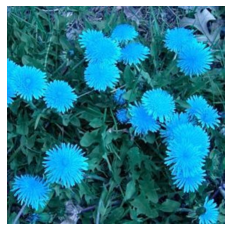

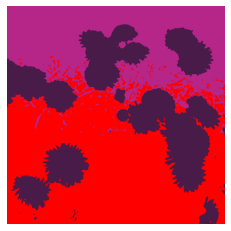

1


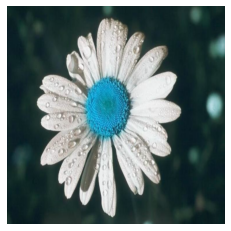

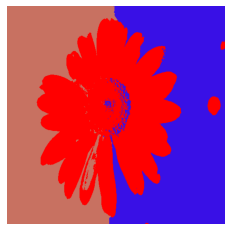

2


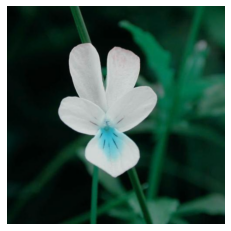

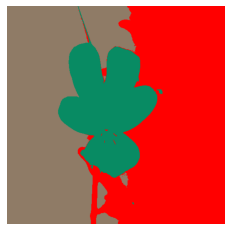

3


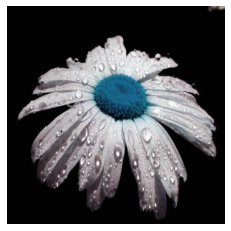

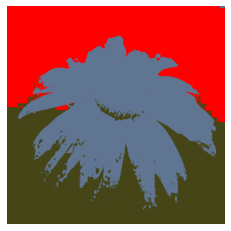

4


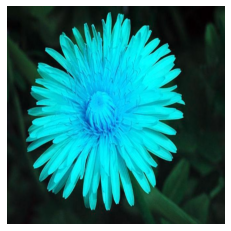

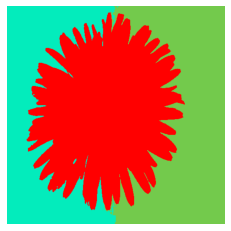

5


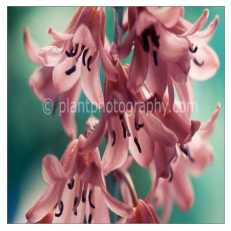

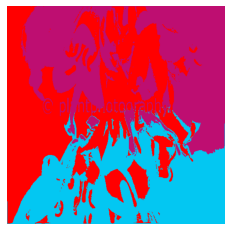

6


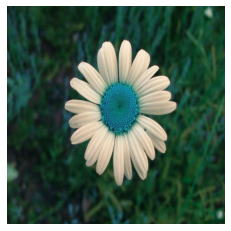

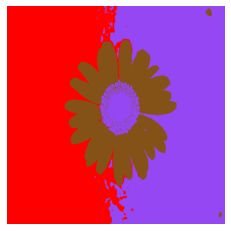

7


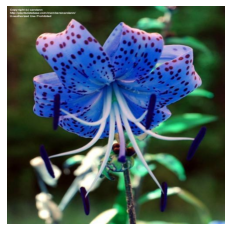

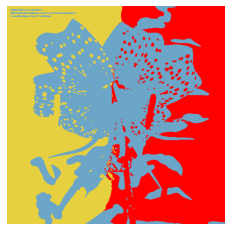

8


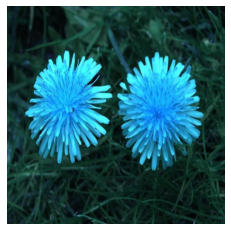

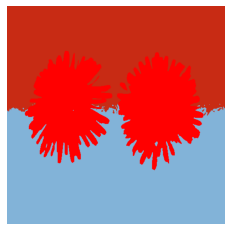

9


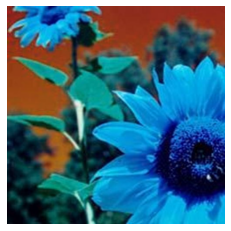

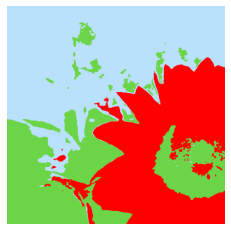

In [63]:
test_finding_flower(10)

C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python31

number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3


C:\Users\mashadservice\AppData\Local\Temp\ipykernel_10856\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3


C:\Users\mashadservice\AppData\Local\Temp\ipykernel_10856\961305389.py:17: RuntimeWarning: invalid value encountered in scalar divide
  a2 = np.sum((hue[right_indices] - np.mean(hue)) * normalized_distance[right_indices]) / np.sum(normalized_distance[right_indices]**2)


number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before d

C:\Users\mashadservice\AppData\Local\Temp\ipykernel_10856\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2


C:\Users\mashadservice\AppData\Local\Temp\ipykernel_10856\961305389.py:17: RuntimeWarning: invalid value encountered in scalar divide
  a2 = np.sum((hue[right_indices] - np.mean(hue)) * normalized_distance[right_indices]) / np.sum(normalized_distance[right_indices]**2)


number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before d

C:\Users\mashadservice\AppData\Local\Temp\ipykernel_10856\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2


C:\Users\mashadservice\AppData\Local\Temp\ipykernel_10856\961305389.py:17: RuntimeWarning: invalid value encountered in scalar divide
  a2 = np.sum((hue[right_indices] - np.mean(hue)) * normalized_distance[right_indices]) / np.sum(normalized_distance[right_indices]**2)


number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before d

C:\Users\mashadservice\AppData\Local\Temp\ipykernel_10856\73343215.py:3: RuntimeWarning: invalid value encountered in scalar divide
  avg_distance = np.sum(np.abs(np.subtract.outer(size_of_cluster, size_of_cluster))) / (


number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before delete2
number clusters after delete1
number clusters before d

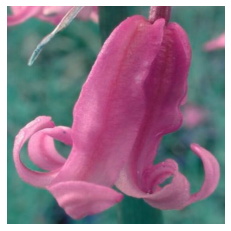

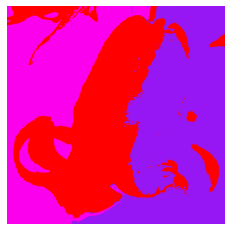

1


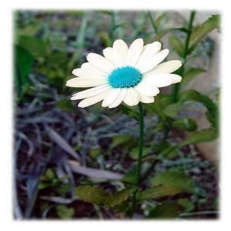

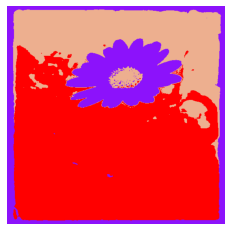

2


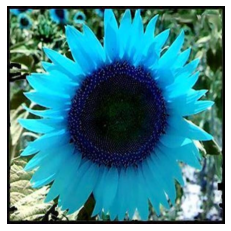

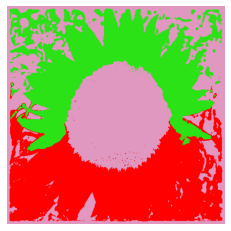

3


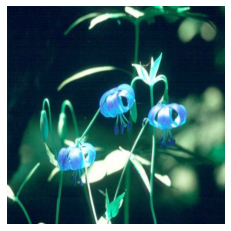

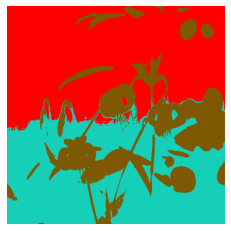

4


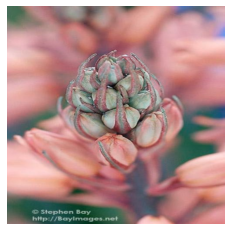

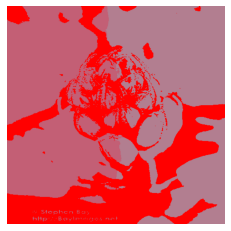

5


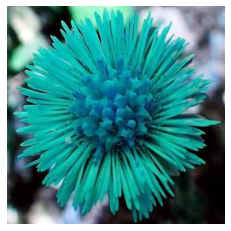

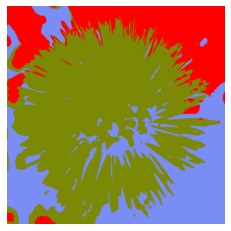

6


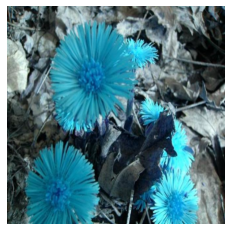

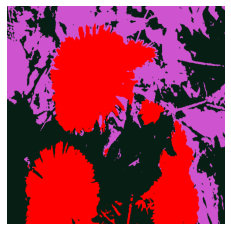

7


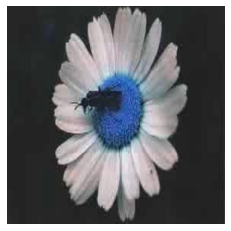

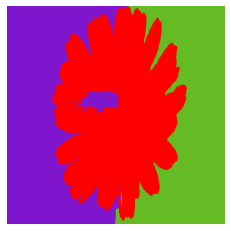

8


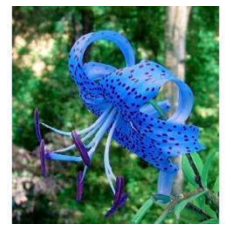

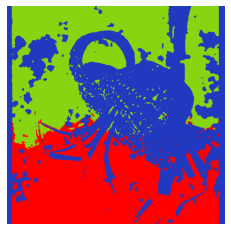

9


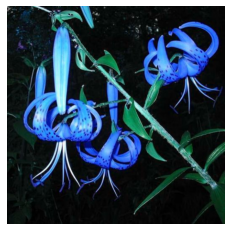

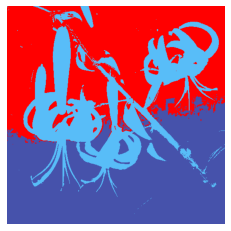

10


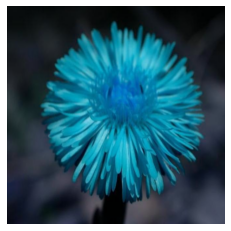

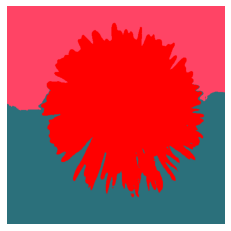

11


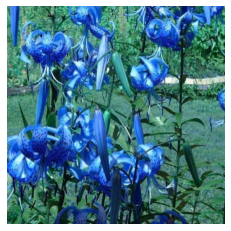

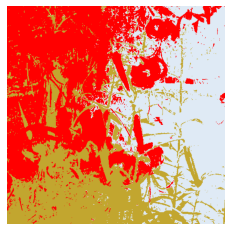

12


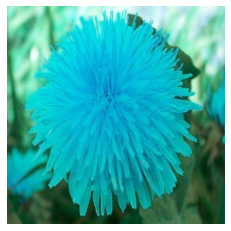

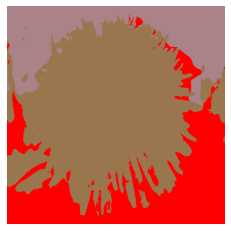

13


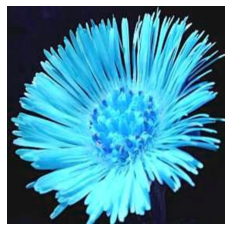

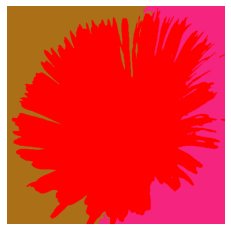

14


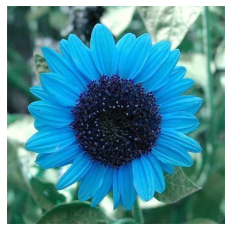

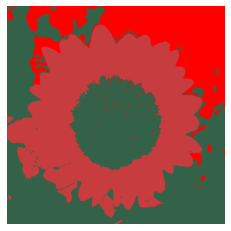

15


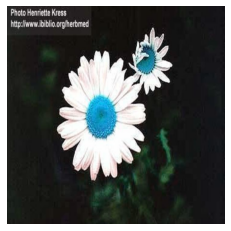

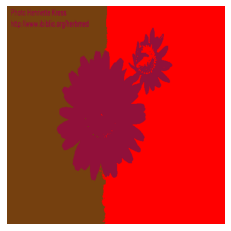

16


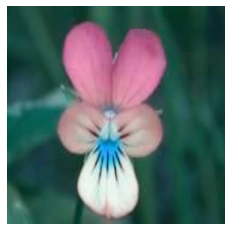

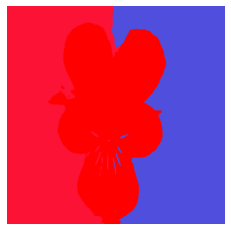

17


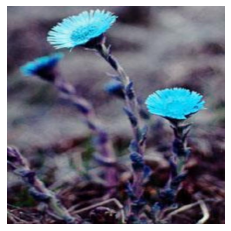

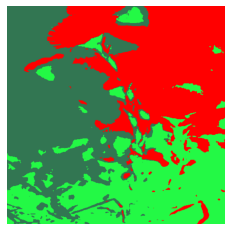

18


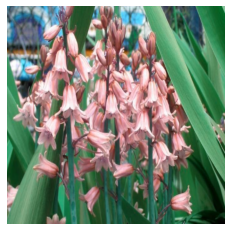

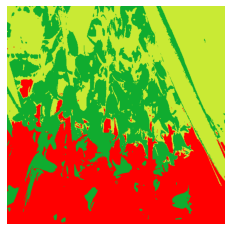

19


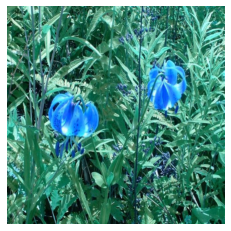

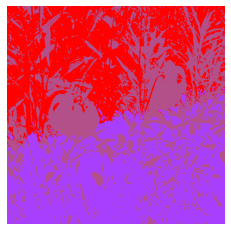

20


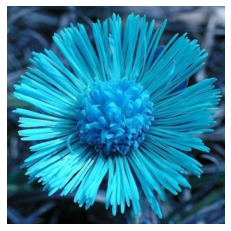

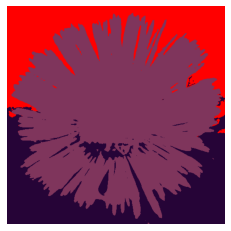

21


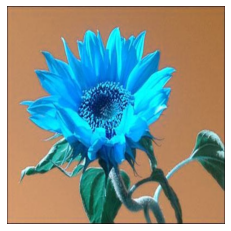

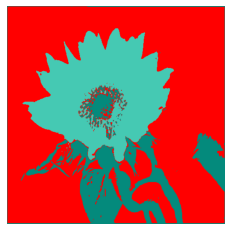

22


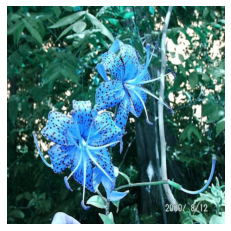

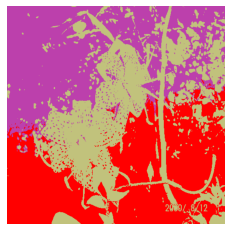

23


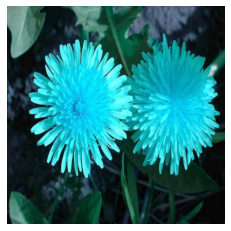

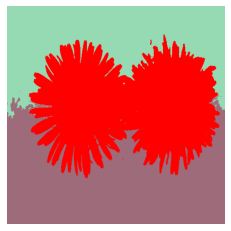

24


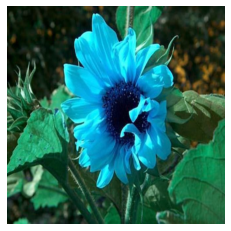

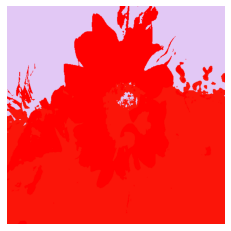

25


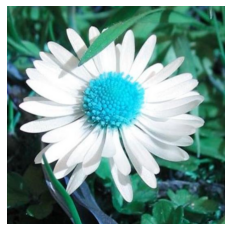

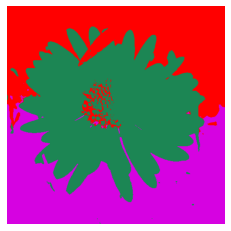

26


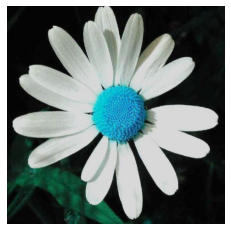

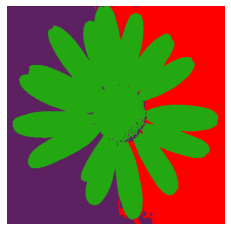

27


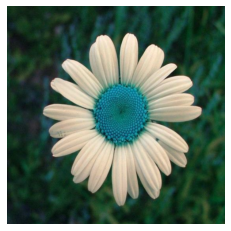

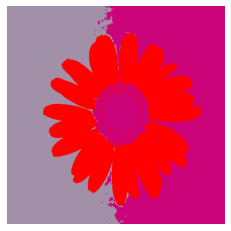

28


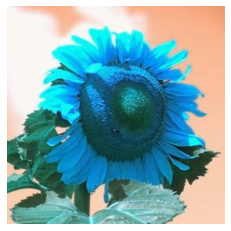

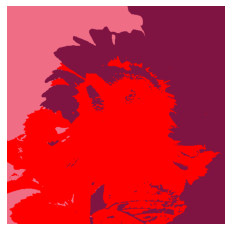

29


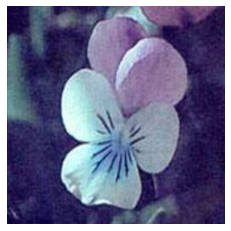

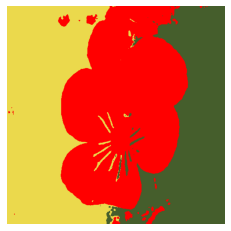

30


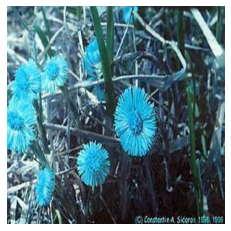

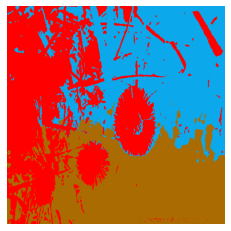

31


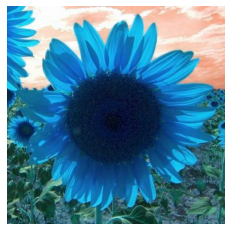

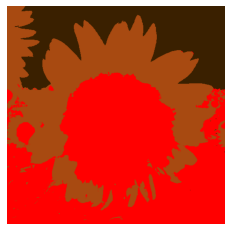

32


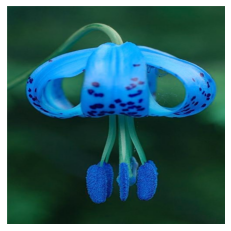

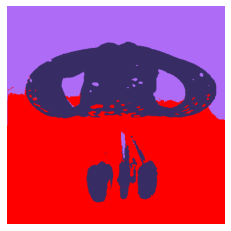

33


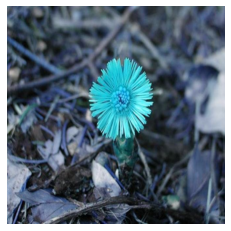

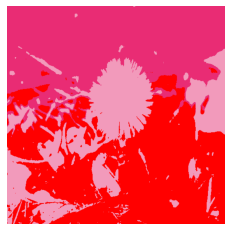

34


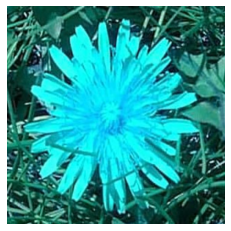

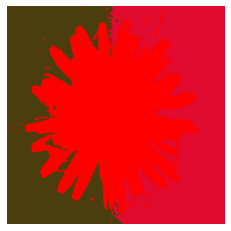

35


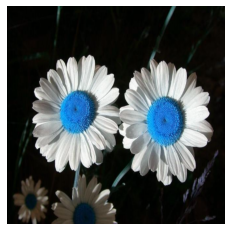

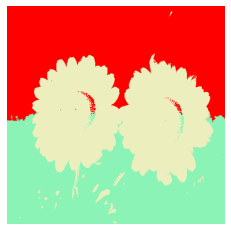

36


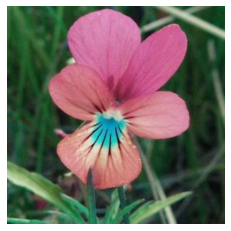

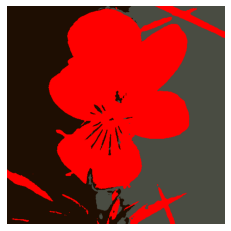

37


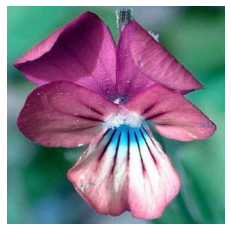

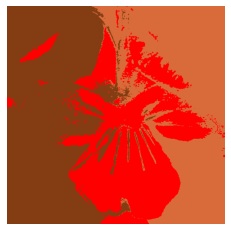

38


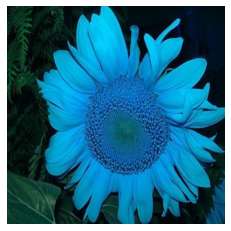

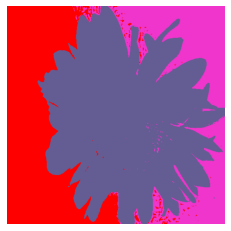

39


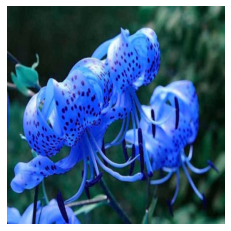

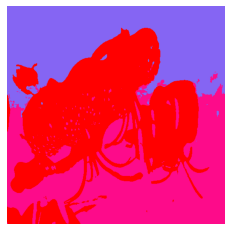

In [64]:
test_finding_flower(40)

In [17]:

def calculate_feature_correlation(feature, selected_features):
    correlation_values = []
    print(f"features shape {feature.shape}")
    print(f"selected features shape  {selected_features.shape}")
    for i in range(selected_features.shape[1]):
        print(f"selected feature {i} shape  {selected_features[:, i].shape}")
        print(f"selected feature {i} shape after reshape {selected_features[:, i].reshape(-1, 1).shape}")
        correlation = np.corrcoef(feature,selected_features[:, i].reshape(-1, 1))[0, 1]
        correlation_values.append(correlation)
    average_correlation = np.mean(correlation_values)
    return average_correlation

In [18]:
def delete_empty_columns(array):
    # Get the column indices where all values are zero
    empty_cols = np.where(~array.any(axis=0))[0]
    
    # Delete the empty columns
    result = np.delete(array, empty_cols, axis=1)
    
    return result

In [19]:

def select_features(feature_vector, labels):
    accuracies = []
    feature_vectors = np.array(feature_vector)
    scaler = StandardScaler()
    feature_vectors = scaler.fit_transform(feature_vectors[:, :])
    selected_features = np.empty_like(feature_vectors[:, :6])
    for i in range(feature_vectors.shape[1]):
        _, _, _, accuracy = classify_for_delete(feature_vectors[:, i].reshape(-1, 1), labels)
        accuracies.append(accuracy) 
    j = 1
    accuracy = 0
    while j <= 6 and  accuracy > 40 :
        best_feature_index = None
        best_combination_score = None
        for i in range(feature_vectors.shape[1]):
            if len(selected_features) == 0:
                correlation = 1
            else:
                correlation = calculate_feature_correlation(feature_vectors[:, i].reshape(-1, 1), selected_features)
            correlation_score = 1 - correlation
            if correlation_score != 0 and accuracies[i] != 0:
                combination_score = 2 / (1 / accuracies[i] + 1/ correlation_score)
            else:
                combination_score = 0

            if best_feature_index is None or combination_score > best_combination_score:
                best_feature_index = i
                best_combination_score = combination_score
        selected_features [:,j] = feature_vectors[:, best_feature_index]
        print(f"best index is {best_feature_index}")
        # Concatenate the selected features horizontally to form a new 2D array
        feature_vectors = np.delete(feature_vectors, best_feature_index, axis=1)
        _, _, _, accuracy = classify_for_delete(selected_features, labels)
    selected_features = delete_empty_columns(selected_features)
    return selected_features

In [20]:
def check_list_dimensions(feature_vector):
    print(len(feature_vector))
    print(len(feature_vector[0]))


In [21]:
def MatrixCal(true_labels,predicted_labels):

# Create the confusion matrix
   confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Create a pandas DataFrame for better visualization
   confusion_df = pd.DataFrame(confusion_mat, index=['True1', 'True2', 'True3', 'True4', 'True5', 'True6', 'True7'],
                             columns=['Pred1', 'Pred2', 'Pred3', 'Pred4', 'Pred5', 'Pred6', 'Pred7'])

   print("Confusion Matrix:")
   print(confusion_df)

# Calculate the precision, recall, f1-score, and accuracy
   precision = precision_score(true_labels, predicted_labels, average='weighted')
   recall = recall_score(true_labels, predicted_labels, average='weighted')
   f1 = f1_score(true_labels, predicted_labels, average='weighted')
   accuracy = accuracy_score(true_labels, predicted_labels)

   print("\nPrecision:", precision)
   print("Recall:", recall)
   print("F1-score:", f1)
   print("Accuracy:", accuracy)
   return confusion_mat

In [22]:
def testConfusion(true_labels,predicted_labels):

    # Step 1: Determine the number of unique labels
    unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))
    n_labels = len(unique_labels)

    # Step 2: Create a new confusion matrix with the correct dimensions
    cm_new = np.zeros((n_labels, n_labels), dtype=int)

    # Step 3: Update the confusion matrix
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        true_index = np.where(unique_labels == true_label)[0][0]
        predicted_index = np.where(unique_labels == predicted_label)[0][0]
        cm_new[true_index, predicted_index] += 1

    
    print(cm_new)
    return cm_new

In [23]:
def mistake_score_proba(y_test, y_pred_proba):
    mistake_list = []
    for i in range(len(y_test)):
        mistake = 0
        for j in range(len(y_pred_proba[i])):
            if j != (y_test[i]-1):
                mistake += y_pred_proba[i][j]

        mistake_list.append(mistake)
    return  mistake_list

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_mistake_score2(delete_percentage, featuer_vector, labels):
    X_train, X_test, y_train, y_test = train_test_split(featuer_vector, labels , test_size=0.3, random_state=42)

    # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=100)

    # Train the classifier to take the training features and learn how they relate to the training y (the species)
    clf.fit(X_train, y_train)

    # Use the predict_proba function to estimate the class probabilities of the test instances
    y_pred_proba = clf.predict_proba(X_test)
    mistakes_value = mistake_score_proba(y_test,y_pred_proba)
    
    numberDelete = int(delete_percentage * len(featuer_vector))
    i = 0
    print(f"data X-test {X_test}")
    print(f"data mistake values {mistakes_value}")
    while i < numberDelete:
        max_value = max(mistakes_value)
        max_index = mistakes_value.index(max_value)
        mistakes_value[max_index] = -2
        print(f"max index in mistakes is {max_index}")
       
            # Find the index where x_test_value exists in featuer_vector
        index = np.where(np.all(np.isclose(featuer_vector,X_test[max_index] ), axis=1))[0][0]

        # Delete misclassified data point from featuer_vector and its label from labels
        featuer_vector = np.delete(featuer_vector, index, axis=0)
        labels = np.delete(labels, index, axis=0)
        i += 1
   

    return featuer_vector, labels




In [31]:
def testDelete(num):
    images2, labels2, features2 = load_dataset()

    random_indices = random.sample(range(len(images2)), num)

    # images = [images2[i] for i in random_indices]
    labels = [labels2[i] for i in random_indices]
    features = [features2[i] for i in random_indices]

    images_cluster,images_flower_index,images_width,images_height, images_pixel_lables,feature_vector = find_flower_cluster(features,labels)
    
    true_labels, predicted_labels,data,accuracy =classify_for_delete(feature_vector,labels)
    
    print("true labels:")
    print( true_labels)
   
    print("predicted labels:")
    print( predicted_labels)
    print("len true_labels"+str(len(true_labels)))
    print("len feature_vector"+str(len(feature_vector)))
    
    # testConfusion(true_labels,predicted_labels)
    # calculate_mistake_score(true_labels,predicted_labels)
    print("before delete mistakes")
    print("len cleaned_data"+str(len(feature_vector)))
    
    print("len new labels "+str(len(labels)))
    
    new_features , new_labels = calculate_mistake_score2(0.2, feature_vector, labels)
    print("after delete mistakes")
    print("len cleaned_data"+str(len(new_features)))
    
    print("len new labels "+str(len(new_labels)))
    
    print("///////////////////////////")
    print("finall accuray:")
    print("new feature vector")
    
    true_labels, predicted_labels,accuracy =classify(new_features,new_labels)
    print(accuracy)
    # print(f"before deleting {accuracy}")
    # print(f"before deleting {len(predicted_labels)}")
    # consfusion_mat = MatrixCal(true_labels,predicted_labels)
    # print(consfusion_mat)
    # cleaned_data, cleaned_labels =delete_mistakes(feature_vector, true_labels, predicted_labels, 0.2,consfusion_mat )
    # print(len(cleaned_data))
    # print("after deleting ")
    # check_list_dimensions(cleaned_data)
    # _,_,accuracy =classify(cleaned_data.reshape(48, 7),cleaned_labels)
    # print(f"after deleting {accuracy}")
    # print(f"after deleting {len(cleaned_data)}")

In [ ]:
testDelete(20)

C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python31

number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3


C:\Users\mashadservice\AppData\Local\Temp\ipykernel_13512\961305389.py:13: RuntimeWarning: invalid value encountered in scalar divide
  a1 = np.sum((hue[left_indices] - np.mean(hue)) * normalized_distance[left_indices]) / np.sum(normalized_distance[left_indices]**2)


number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3


C:\Users\mashadservice\AppData\Local\Temp\ipykernel_13512\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3


In [32]:
testDelete(10)

C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python31

number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
Accuracy: 0.00%
0.0
in loop  1
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after d

In [36]:
def replace_nan_with_column_average(data):
   
    # Calculate column averages ignoring NaN values
    column_averages = np.nanmean(data, axis=0)

    # Find NaN indices
    nan_indices = np.isnan(data)

    # Replace NaN values with column averages
    data[nan_indices] = np.take(column_averages, np.where(nan_indices)[1])

    return data

In [38]:
def testSelectFeature(num):
    images2, labels2, features2 = load_dataset()

    random_indices = random.sample(range(len(images2)), num)

    # images = [images2[i] for i in random_indices]
    labels = [labels2[i] for i in random_indices]
    features = [features2[i] for i in random_indices]

    images_cluster,images_flower_index,images_width,images_height, images_pixel_lables,feature_vector = find_flower_cluster(features,labels)
    print("dimension check start")
    check_list_dimensions(feature_vector)
    print("dimension check end")
    true_labels, predicted_labels,accuracy =classify(feature_vector,labels)
    print(f"before deleting {accuracy}")
    # print(f"before deleting {len(predicted_labels)}")
    feature_vector = select_features(feature_vector, labels)
    print("after select_features ")
    check_list_dimensions(feature_vector)
    print (feature_vector[0])
    print("----------------")
    print (feature_vector[1])
    feature_vector = replace_nan_with_column_average(feature_vector)
    _,_,accuracy = classify_for_delete(feature_vector,labels)
    # _,_,accuracy =classify(cleaned_data.reshape(48, 7),cleaned_labels)
    print(f"after select features {accuracy}")
    # print(f"after deleting {len(cleaned_data)}")

In [ ]:
testSelectFeature(30)

In [118]:
testSelectFeature(20)

C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mashadservice\AppData\Local\Programs\Python\Python31

number clusters before delete3
number clusters after delete3


C:\Users\mashadservice\AppData\Local\Temp\ipykernel_13844\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before delete3
number clusters after delete3
number clusters before d

C:\Users\mashadservice\AppData\Local\Temp\ipykernel_13844\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before d

C:\Users\mashadservice\AppData\Local\Temp\ipykernel_13844\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before d

C:\Users\mashadservice\AppData\Local\Temp\ipykernel_13844\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
Accuracy: 25.00%
cluster number after loop 13
cluster number after loop 13
cluster number after max 13
cluster number after max 13
number clusters before delete3
number clusters after delete2


C:\Users\mashadservice\AppData\Local\Temp\ipykernel_13844\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before d

C:\Users\mashadservice\AppData\Local\Temp\ipykernel_13844\961305389.py:25: RuntimeWarning: invalid value encountered in scalar divide
  a4 = np.sum((hue[bottom_indices] - np.mean(hue)) * normalized_distance[bottom_indices]) / np.sum(normalized_distance[bottom_indices]**2)


number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before delete3
number clusters after delete2
number clusters before d

In [ ]:
images2, labels2, features2 = load_dataset()

random_indices = random.sample(range(len(images2)), 50)

# images = [images2[i] for i in random_indices]
labels = [labels2[i] for i in random_indices]
features = [features2[i] for i in random_indices]

images_cluster,images_flower_index,images_width,images_height, images_pixel_lables,feature_vector = find_flower_cluster(features,labels)

true_labels, predicted_labels,data,accuracy =classify_for_delete(feature_vector,labels)



print(feature_vector)
# testConfusion(true_labels,predicted_labels)
# calculate_mistake_score(true_labels,predicted_labels)
# print("before delete mistakes")
new_features , new_labels = calculate_mistake_score2(data, true_labels, predicted_labels, 0.2,feature_vector,labels )
# print("after delete mistakes")
# print("len cleaned_data"+str(len(cleaned_data)))
# print("len cleaned_labels"+ str(len(cleaned_labels)))
# print("dataset new "+str(len(new_features)))
# print("new labels dataset"+str(len(new_labels)))
# print("finall accuray:")
# print("new feature vector")
# print(new_features)
# true_labels, predicted_labels,accuracy =classify(cleaned_data,cleaned_labels)
# print(accuracy)
feature_vector = select_features(new_features, new_labels)
# print("after deleting ")
check_list_dimensions(feature_vector)
feature_vector = replace_nan_with_column_average(feature_vector)
_, _,_,accuracy =classify_for_delete(feature_vector,new_labels)
print("final accuray is ")
print(accuracy)